<a href="https://colab.research.google.com/github/samartha007/Psoriasis-detection-using-transfer-learning/blob/New-random-sampling-method/Final_Mobile_net_parameter_tuweking_with_ROC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,Dropout
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_curve,auc


from keras.applications.mobilenet import MobileNet
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
#### Modeling
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from tensorflow.keras.optimizers import Adam,SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import EfficientNetB0
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import cross_val_score,cross_val_predict, StratifiedKFold
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc



In [2]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [3]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import preprocess_input

# Path to the directories containing the class data
class_1_directory = '/content/gdrive/MyDrive/all patch data/all patch data/updated_new_data_disease'
class_2_directory = '/content/gdrive/MyDrive/all patch data/all patch data/New_updated normal/Selected_Normal_Patch_Data'

# Get a list of image filenames for each class
class_1_filenames = os.listdir(class_1_directory)
class_2_filenames = os.listdir(class_2_directory)

# Create empty lists to store the data and labels
data = []
labels = []

# Loop over each image in class 1
for image_filename in class_1_filenames:
    # Read the image
    image_path = os.path.join(class_1_directory, image_filename)
    image = Image.open(image_path)

    # Preprocess the image for VGG16
    image = image.resize((224, 224))
    # image = image.convert('RGB')
    image = np.array(image)
    # image = preprocess_input(image)

    # Add the preprocessed image and corresponding label to the lists
    data.append(image)
    labels.append(0)  # Class 1 is labeled as 0

# Loop over each image in class 2
for image_filename in class_2_filenames:
    # Read the image
    image_path = os.path.join(class_2_directory, image_filename)
    image = Image.open(image_path)

    # Preprocess the image for VGG16
    image = image.resize((224, 224))
    # image = image.convert('RGB')
    image = np.array(image)
    # image = preprocess_input(image)

    # Add the preprocessed image and corresponding label to the lists
    data.append(image)
    labels.append(1)  # Class 2 is labeled as 1

# Convert the lists to NumPy arrays
data = np.array(data)
labels = np.array(labels)
# # Normalize the image data
data = data / 255.0
# Split the data into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(data, labels, test_size=0.2, random_state=42)


In [12]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,Dropout
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## Mobilenet
# Set the random seed
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

from keras.applications.mobilenet import MobileNet

# Step 2: Load a pre-trained model (VGG16 in this example)
base_model =MobileNet(
    input_shape=(224,224,3),
    alpha=1.0,
    depth_multiplier=1,
    dropout=0.001,
    include_top=False
)

# Step 3: Build your model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(224, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
base_model.trainable=False
# Step 4: Compile your model
model.compile(optimizer=SGD(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Step 5: Train your model
model.fit(X_train1, y_train1, epochs=1, validation_data=(X_test1, y_test1))
model.save('/content/mode.h5')
# Step 6: Evaluate your model
y_pred = model.predict(X_test1)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test1, y_pred_binary)
precision = precision_score(y_test1, y_pred_binary)
recall = recall_score(y_test1, y_pred_binary)
f1 = f1_score(y_test1, y_pred_binary)
confusion_mat = confusion_matrix(y_test1, y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", confusion_mat)


6/6 [==============================] - 1s 34ms/step
Accuracy: 0.9722222222222222
Precision: 0.961038961038961
Recall: 0.9736842105263158
F1 Score: 0.9673202614379085
Confusion Matrix:
 [[101   3]
 [  2  74]]


In [6]:
## For calculation of ROC with out using the roc_auc function
def calculate_roc_curve(y_true, y_score):
    # Step 1: Input Preparation
    y_true = np.array(y_true)
    y_score = np.array(y_score)

    # Step 2: Sorting
    sorted_indices = np.argsort(y_score, kind='mergesort')[::-1]
    sorted_y_true = y_true[sorted_indices]
    sorted_y_score = y_score[sorted_indices]

    # Step 3, 4, and 5: Threshold Calculation, TPR Calculation, and FPR Calculation
    num_positives = np.sum(sorted_y_true)
    num_negatives = len(sorted_y_true) - num_positives
    tpr_list = []
    fpr_list = []
    thresholds = []

    tp = 0
    fp = 0

    for i in range(len(sorted_y_true)):
        if sorted_y_true[i] == 1:
            tp += 1
        else:
            fp += 1

        tpr = tp / num_positives
        fpr = fp / num_negatives

        tpr_list.append(tpr)
        fpr_list.append(fpr)
        thresholds.append(sorted_y_score[i])

    return fpr_list, tpr_list, thresholds

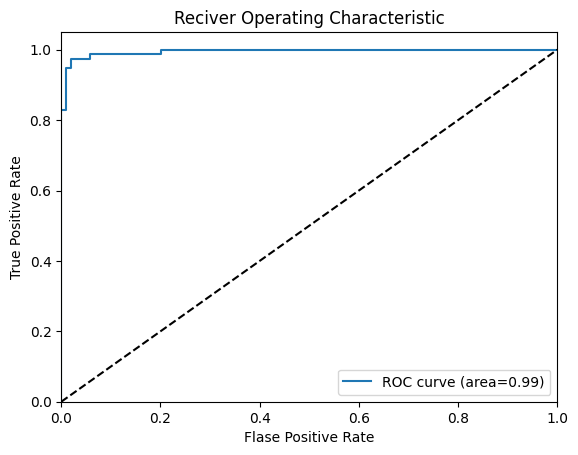

In [13]:
## Computing the ROC Curve
fpr,tpr,threshold=roc_curve(y_test1,y_pred)
## Compute AUC
roc_auc=auc(fpr,tpr)
## Plot the ROC
plt.figure()
plt.plot(fpr,tpr,label='ROC curve (area=%0.2f)'% roc_auc)
plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('Flase Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Reciver Operating Characteristic")
plt.legend(loc='lower right')
plt.show()

In [10]:
# Example usage:
y_true = [0, 1, 0, 1, 1, 0, 0, 1]
y_score = [0.2, 0.6, 0.3, 0.8, 0.9, 0.4, 0.1, 0.7]

fpr_list, tpr_list, thresholds = calculate_roc_curve(y_test1, y_pred)
print("FPR:", fpr_list)
print("TPR:", tpr_list)
print("Thresholds:", thresholds)

FPR: [0.005555555555555556, 0.011111111111111112, 0.016666666666666666, 0.022222222222222223, 0.027777777777777776, 0.03333333333333333, 0.03888888888888889, 0.044444444444444446, 0.05, 0.05555555555555555, 0.06111111111111111, 0.06666666666666667, 0.07222222222222222, 0.07777777777777778, 0.08333333333333333, 0.08888888888888889, 0.09444444444444444, 0.1, 0.10555555555555556, 0.1111111111111111, 0.11666666666666667, 0.12222222222222222, 0.12777777777777777, 0.13333333333333333, 0.1388888888888889, 0.14444444444444443, 0.15, 0.15555555555555556, 0.16111111111111112, 0.16666666666666666, 0.17222222222222222, 0.17777777777777778, 0.18333333333333332, 0.18888888888888888, 0.19444444444444445, 0.2, 0.20555555555555555, 0.2111111111111111, 0.21666666666666667, 0.2222222222222222, 0.22777777777777777, 0.23333333333333334, 0.2388888888888889, 0.24444444444444444, 0.25, 0.25555555555555554, 0.2611111111111111, 0.26666666666666666, 0.2722222222222222, 0.2777777777777778, 0.2833333333333333, 0.2

<ipython-input-6-a1fe413d97c2>:28: RuntimeWarning: invalid value encountered in long_scalars
  tpr = tp / num_positives


In [ ]:
## calculating Specificity and Sensitivity
# Creating a function to report confusion metrics
def f1_scores (conf_matrix):
# save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]

    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))

    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy

    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))

    # calculate precision
    conf_precision = (TN / float(TN + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    return conf_f1,conf_sensitivity,conf_specificity


In [ ]:

#### Model Performance
from sklearn import metrics
def performance(y_true,y_pred_probs):
    cm = metrics.confusion_matrix(y_true, y_pred_probs)
    print('     sensitivity :',(f1_scores(cm)[1]))
    print('     specificity :',(f1_scores(cm)[2]))
# y_true, y_pred_probs
print('Mobilenet ')
performance(y_test1,y_pred_binary)

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test1, y_pred_binary)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## For Mobile Net application using the Newly mentioned method

In [4]:
#### SIR Newly Mentioned Logic of sampling
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
sns=[]
spc=[]
AUC=[]
AUC_by_FPRandTPR=[]
validation_loss=[]
validation_accuracy=[]
# fpr=[]
# tpr=[]

# Assuming you have your feature data in 'X' and labels in 'y'
# Define your model as 'model'
# Define the number of epochs as 'num_epochs'
def sir_method(base,height,width):
# Get the total number of samples
  num_samples = len(labels)
  num_epochs=10
  for epoch in range(num_epochs):
      # Shuffle the data and labels
      shuffled_indices = np.random.permutation(num_samples)
      X_shuffled = data[shuffled_indices]
      y_shuffled =labels[shuffled_indices]

      # Split the data into training and validation sets
      train_size = int(0.8 * num_samples)
      X_train, X_val = X_shuffled[:train_size], X_shuffled[train_size:]
      y_train, y_val = y_shuffled[:train_size], y_shuffled[train_size:]
      base_model = base(weights='imagenet', include_top=False, input_shape=(height, width, 3))

        # Set up the model architecture
      model = Sequential()
      model.add(base_model)
      model.add(Flatten())
      model.add(Dense(height, activation='relu'))
      model.add(Dropout(0.5))
      model.add(Dense(1, activation='sigmoid'))
      base_model.trainable = False

      # Compile the model
      model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
      # Train the model on the training set
      model.fit(X_train, y_train, epochs=1, verbose=0)
      # Evaluate the model on the validation set
      val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
      validation_loss.append(val_loss)
      validation_accuracy.append(val_acc)
      # Make predictions on the validation set
      y_pred = model.predict(X_val)
      # y_pred_prob = model.predict_proba(X_val)[:, 1]

      # Calculate sensitivity, specificity, and AUC
      cm = confusion_matrix(y_val, np.round(y_pred))
      tn, fp, fn, tp = cm.ravel()
      sensitivity = tp / (tp + fn)
      specificity = tn / (tn + fp)
      auc1 = roc_auc_score(y_val, y_pred)
      # roc_auc = roc_auc_score(y_val, y_pred_prob)
      sns.append(sensitivity)
      spc.append(specificity)
      AUC.append(auc1)
      print(auc1)
      y_pred_binary = (y_pred >= 0.5).astype(int)
      # Calculate the ROC curve
      fpr1, tpr1, thresholds = roc_curve(y_val, y_pred)
      ## Computing the ROC Curve
      # fpr,tpr,threshold=roc_curve(y_test1,y_pred)
      ## Compute AUC
      roc_auc=auc(fpr1,tpr1)
      ## Plot the ROC
      plt.figure()
      plt.plot(fpr1,tpr1,label='ROC curve (area=%0.2f)'% roc_auc)
      plt.plot([0,1],[0,1],'k--')
      plt.xlim([0.0,1.0])
      plt.ylim([0.0,1.05])
      plt.xlabel('Flase Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title("Reciver Operating Characteristic")
      plt.legend(loc='lower right')
      plt.show()
  return sns,spc,AUC,validation_loss,validation_accuracy


6/6 [==============================] - 1s 37ms/step
0.9839115133232781


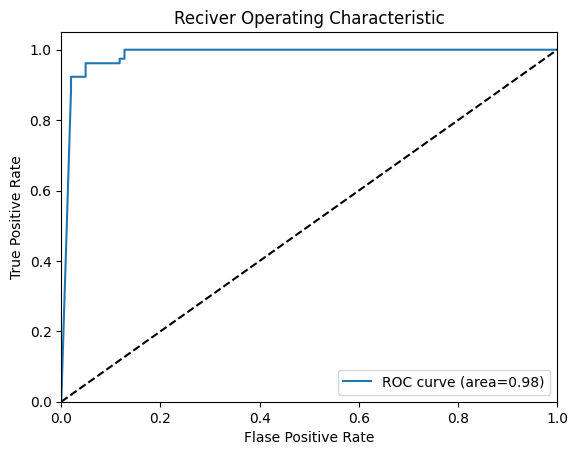

6/6 [==============================] - 1s 33ms/step
0.9920899765171177


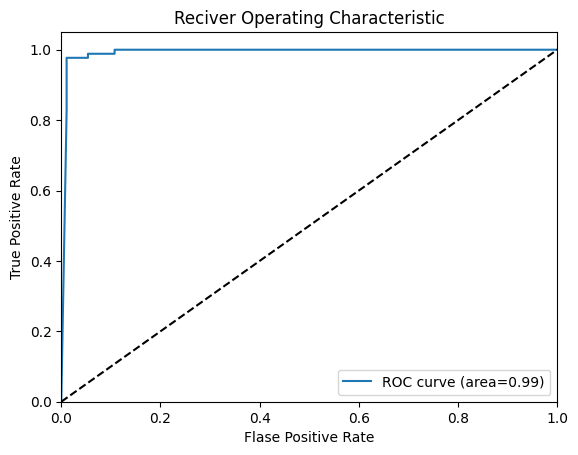

6/6 [==============================] - 1s 32ms/step
0.9752388134741077


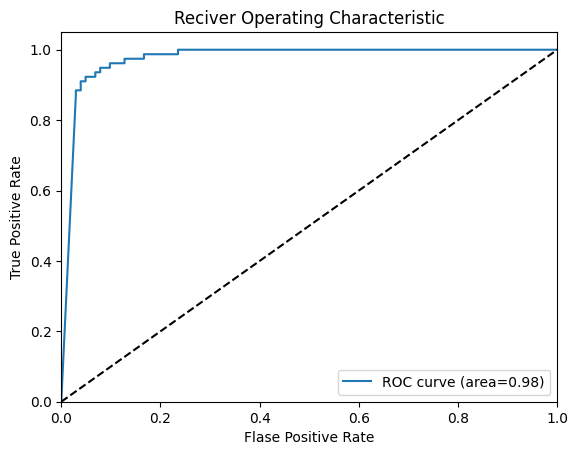

6/6 [==============================] - 1s 39ms/step
0.9985139318885449


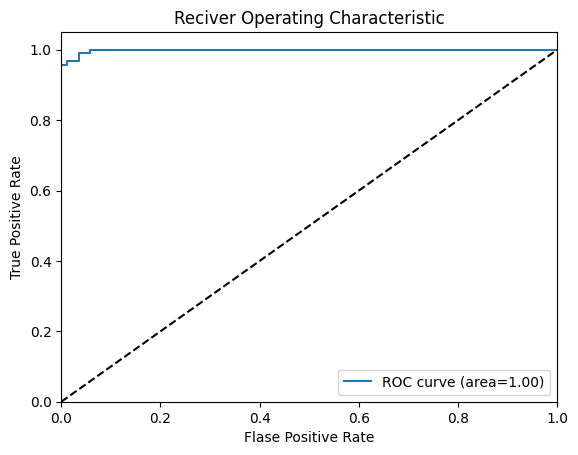

6/6 [==============================] - 1s 32ms/step
0.9472253120751453


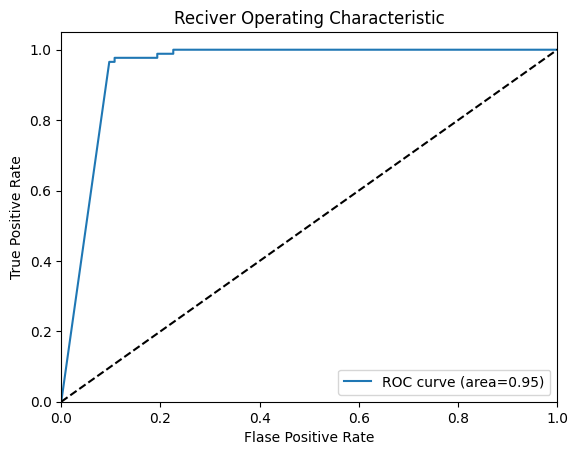

6/6 [==============================] - 1s 33ms/step
0.9927079471017181


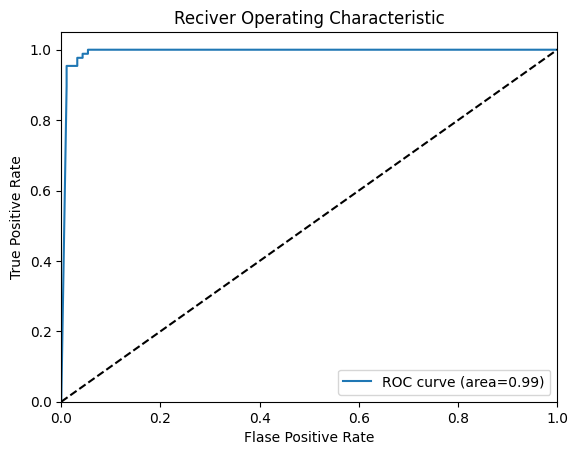

6/6 [==============================] - 1s 40ms/step
0.965757849851402


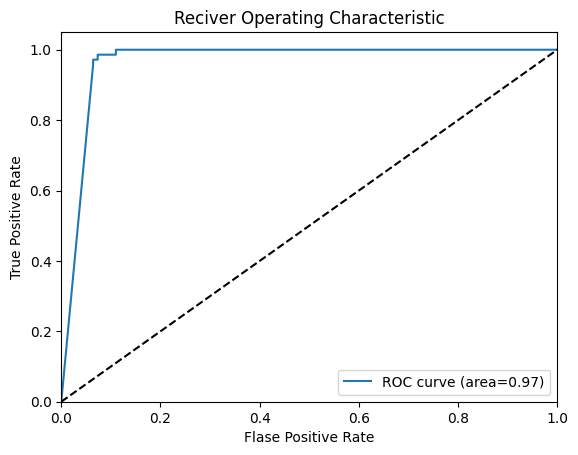

6/6 [==============================] - 1s 32ms/step
0.9825886570221483


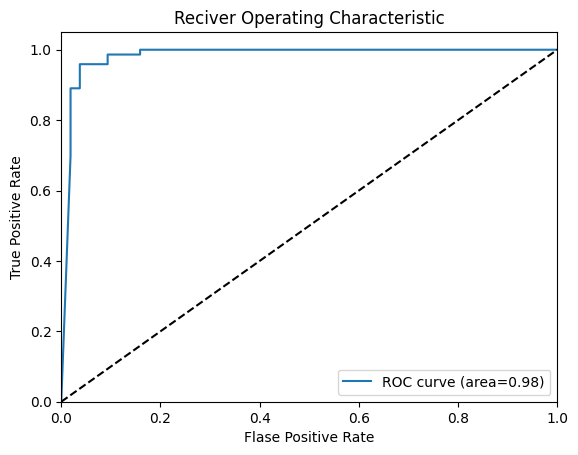

6/6 [==============================] - 1s 35ms/step
0.994314381270903


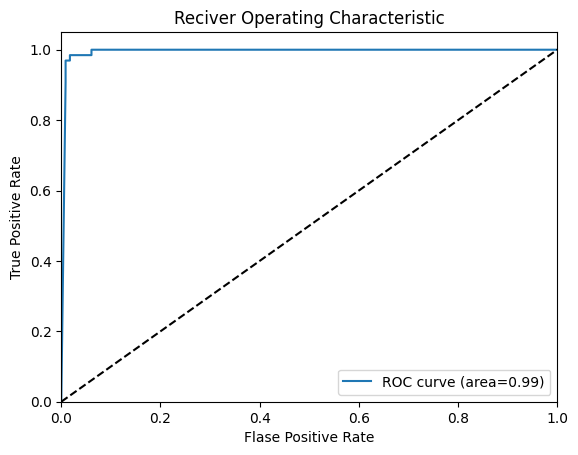

6/6 [==============================] - 1s 37ms/step
0.996656346749226


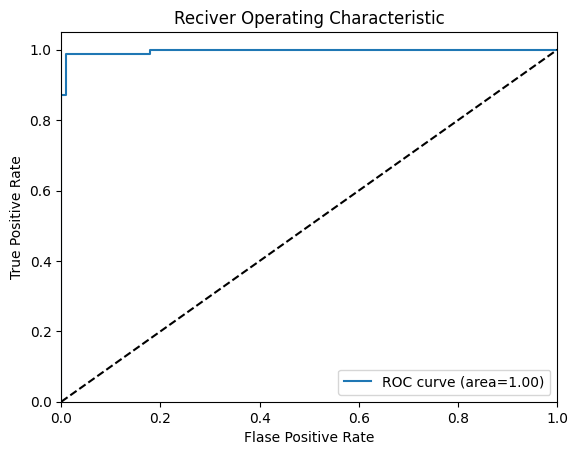

In [15]:
mobile_net_sns,mobile_net_spc,mobile_net_auc,mobile_net_val_loss,mobile_net_val_acc=sir_method(MobileNet,224,224)

In [16]:
print(f'Mean sensitivity of MobileNet after 10 epochs {np.mean(mobile_net_sns)}')
print(f'Mean specificity after 10 epochs {np.mean(mobile_net_spc)}')
print(f'Mean AUC after 10 epochs {np.mean(mobile_net_auc)}')

Mean sensitivity of MobileNet after 10 epochs 0.9781591743676066
Mean specificity after 10 epochs 0.9342473085398924
Mean AUC after 10 epochs 0.9829004729273592


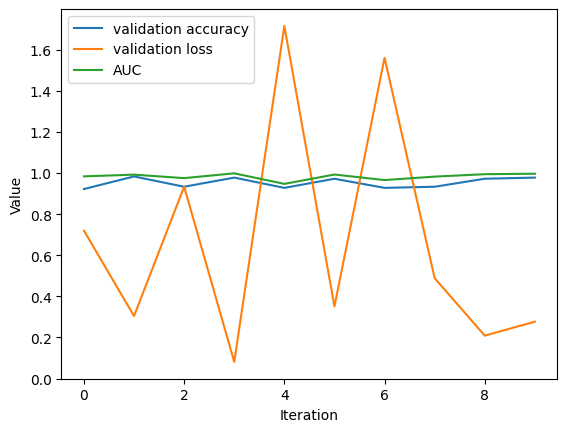

In [17]:

# Generate x-axis values (indices of the data list)
x = range(len(mobile_net_val_acc))

# Plot the data
plt.plot(x, mobile_net_val_acc,label='validation accuracy')
plt.plot(x, mobile_net_val_loss,label='validation loss')
plt.plot(x, mobile_net_auc,label='AUC')
# Add labels and title to the plot
plt.xlabel('Iteration')
plt.ylabel('Value')
# plt.title('Plot of List of Values')
# Adding legend
plt.legend()
# Display the plot
plt.show()

### For Resnet-50 application

6/6 [==============================] - 1s 99ms/step
0.9188520534388916


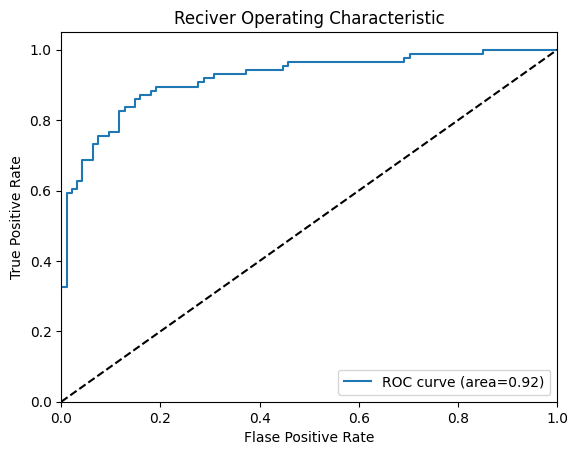

6/6 [==============================] - 2s 101ms/step
0.9056346749226007


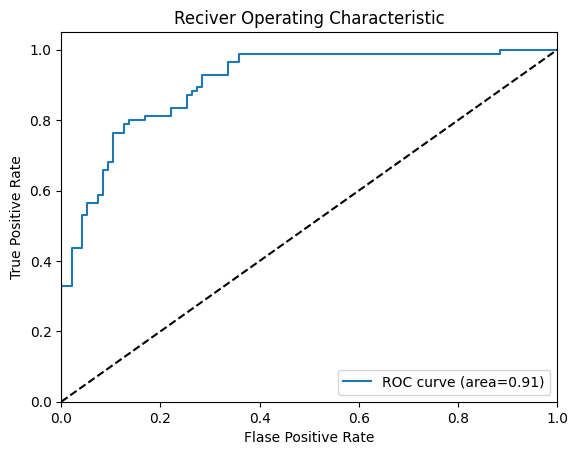

6/6 [==============================] - 1s 86ms/step
0.9359022321985284


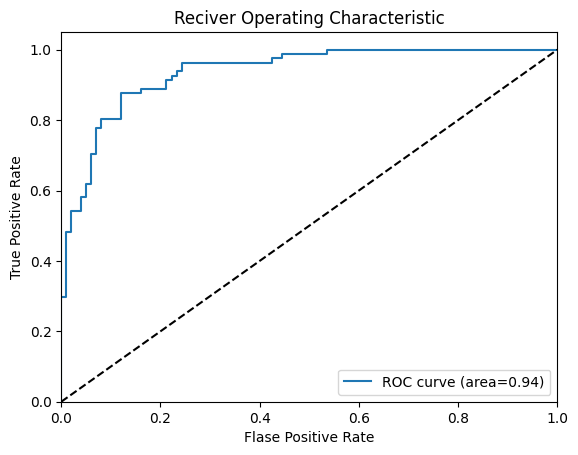

6/6 [==============================] - 2s 89ms/step
0.5


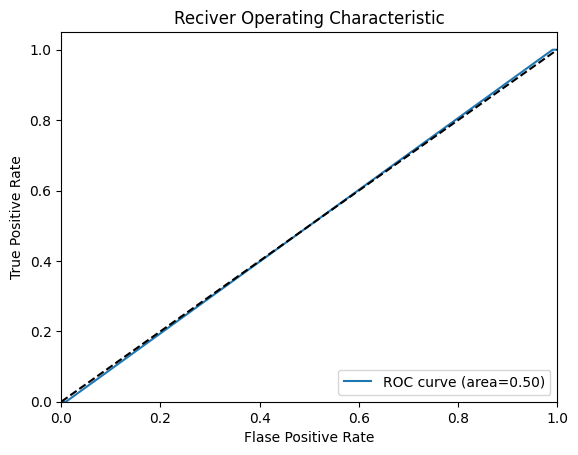

6/6 [==============================] - 1s 86ms/step
0.9297385620915033


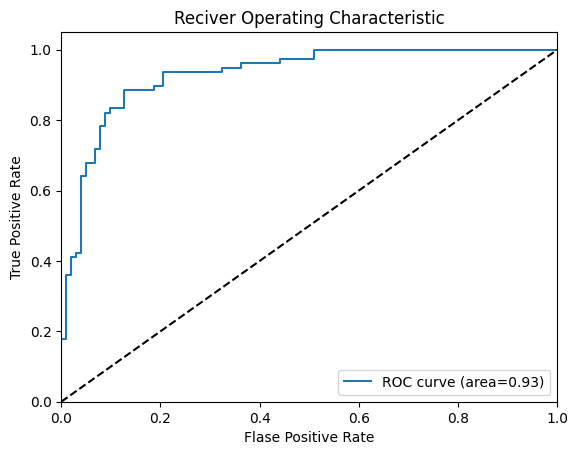

6/6 [==============================] - 1s 86ms/step
0.900516958769386


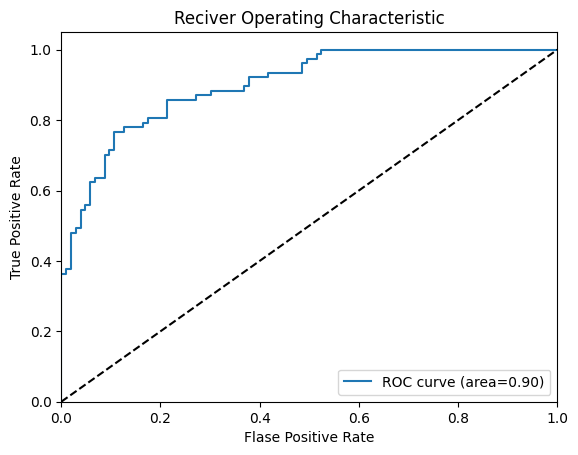

6/6 [==============================] - 1s 88ms/step
0.9240915878546541


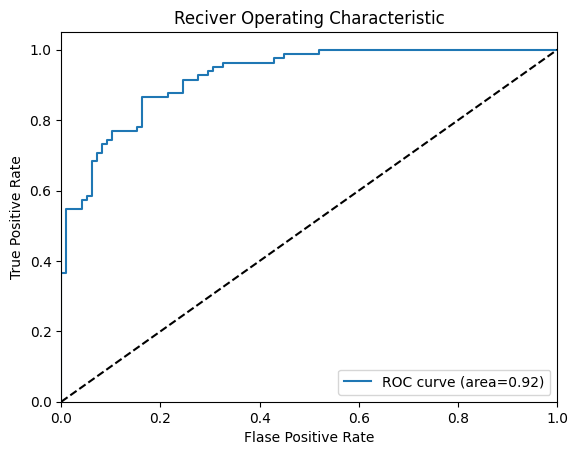

6/6 [==============================] - 1s 89ms/step
0.49504950495049505


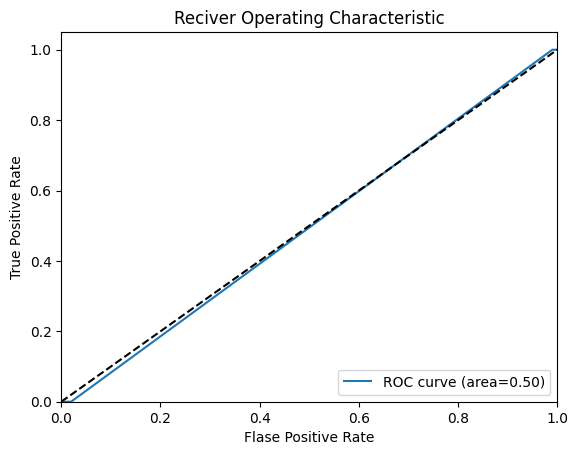

6/6 [==============================] - 1s 97ms/step
0.494949494949495


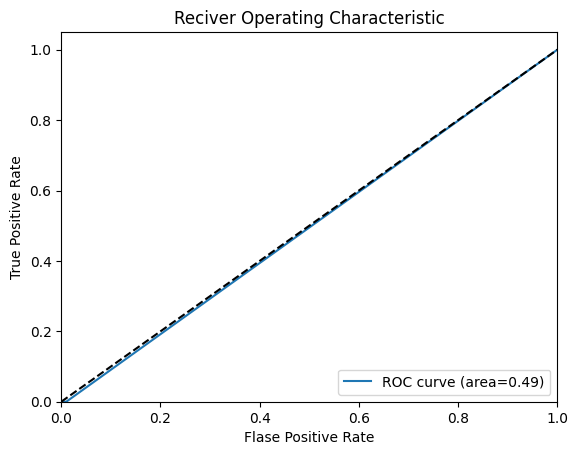

6/6 [==============================] - 1s 87ms/step
0.9060602144979971


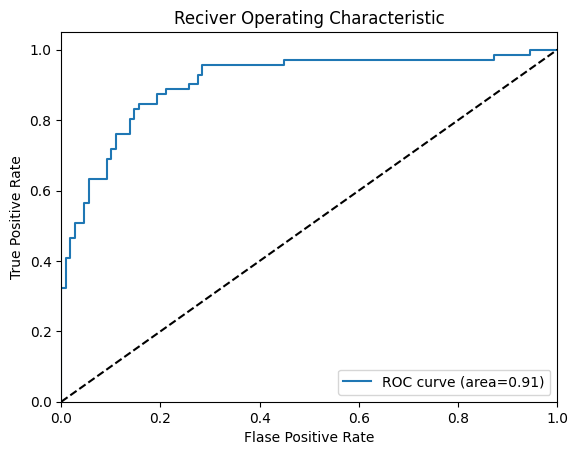

In [18]:
res_net_sns,res_net_spc,res_net_auc,res_net_val_loss,res_net_val_acc=sir_method(ResNet50,224,224)

In [19]:
print(f'Mean sensitivity of VGG16 after 10 epochs {np.mean(res_net_sns)}')
print(f'Mean specificity of VGG16 after 10 epochs {np.mean(res_net_spc)}')
print(f'Mean AUC of VGG16 after 10 epochs {np.mean(res_net_auc)}')

Mean sensitivity of VGG16 after 10 epochs 0.8366395000378336
Mean specificity of VGG16 after 10 epochs 0.6536034693205
Mean AUC of VGG16 after 10 epochs 0.8869900006473571


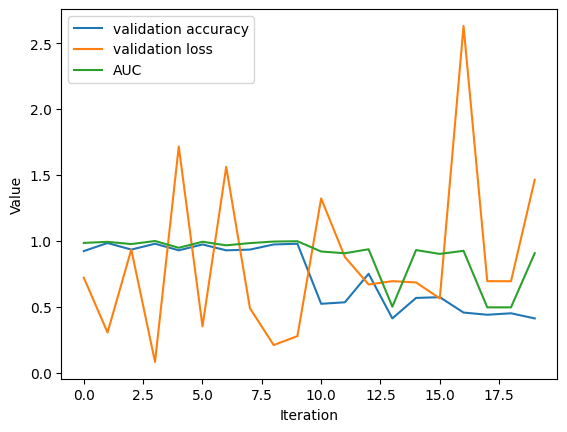

In [20]:
# Generate x-axis values (indices of the data list)
x = range(len(res_net_val_acc))

# Plot the data
plt.plot(x, res_net_val_acc,label='validation accuracy')
plt.plot(x, res_net_val_loss,label='validation loss')
plt.plot(x, res_net_auc,label='AUC')
# Add labels and title to the plot
plt.xlabel('Iteration')
plt.ylabel('Value')
# plt.title('Plot of List of Values')
# Adding legend
plt.legend()
# Display the plot
plt.show()

## For VGG 16 and 19 application

6/6 [==============================] - 1s 123ms/step
0.8785046728971962


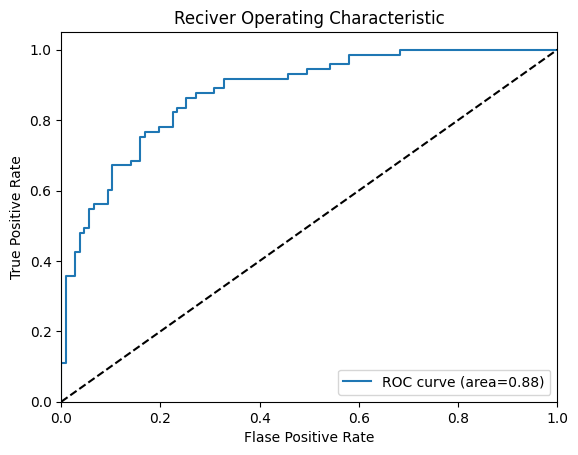

6/6 [==============================] - 1s 113ms/step
0.9172430830039525


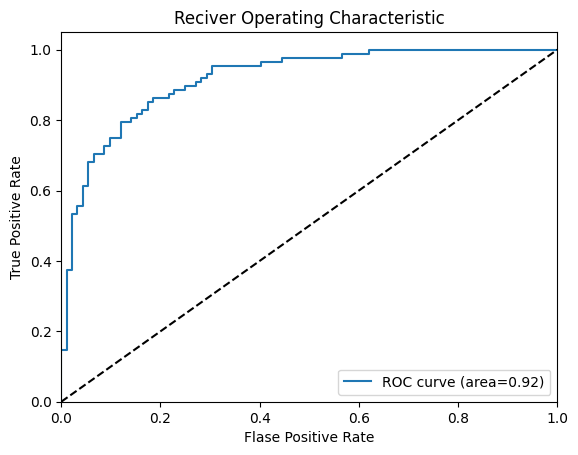

6/6 [==============================] - 1s 113ms/step
0.9202218993527935


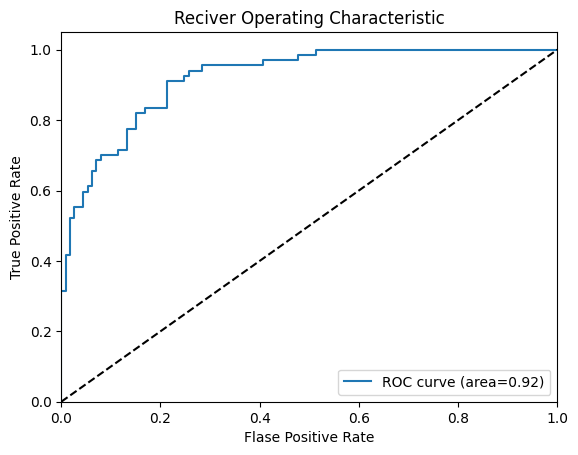

6/6 [==============================] - 1s 116ms/step
0.9525778524357151


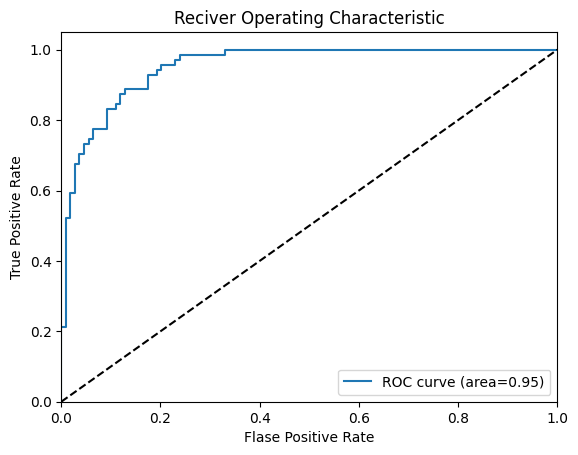

6/6 [==============================] - 1s 117ms/step
0.9657525083612041


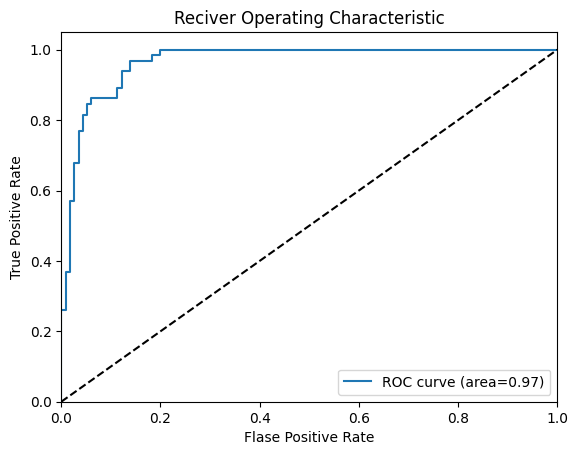

6/6 [==============================] - 1s 115ms/step
0.8916369199388067


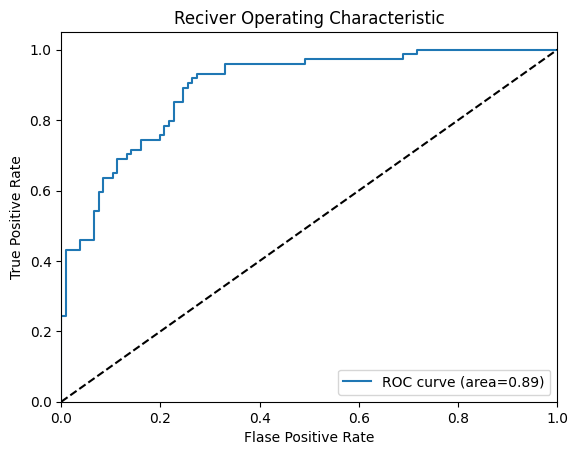

6/6 [==============================] - 1s 114ms/step
0.8972043542800593


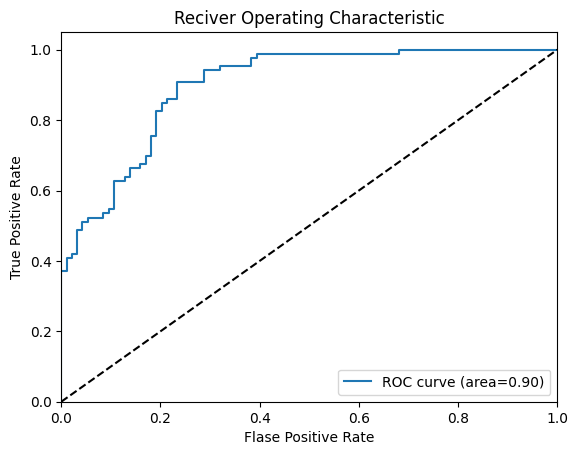

6/6 [==============================] - 1s 115ms/step
0.9191779094691714


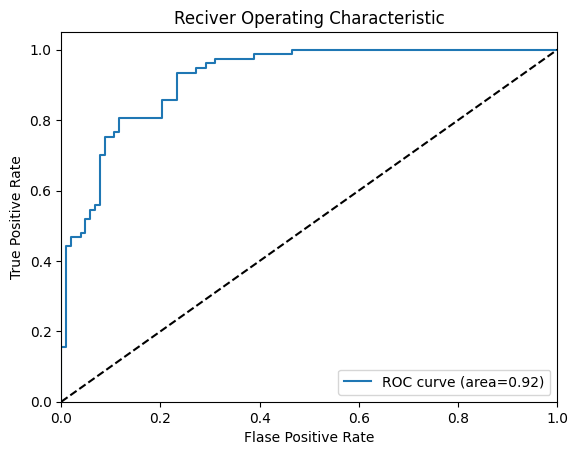

6/6 [==============================] - 1s 117ms/step
0.9057539682539684


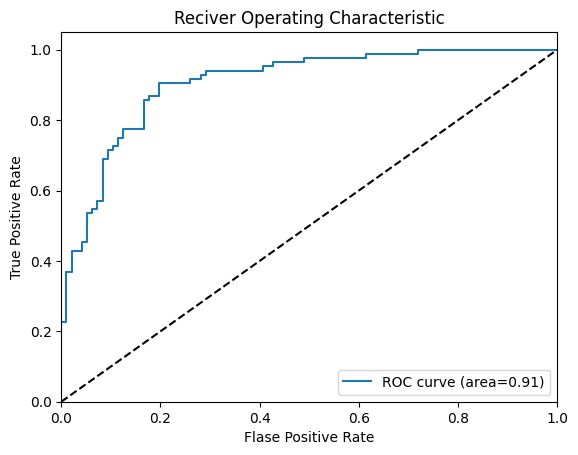

6/6 [==============================] - 1s 117ms/step
0.93575


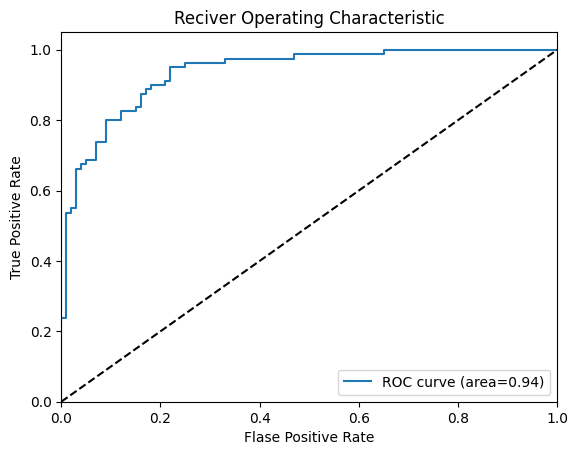

In [5]:
vgg16_sns,vgg16_spc,vgg16_auc,vgg16_val_loss,vgg16_val_acc=sir_method(VGG16,224,224)

In [6]:
print(f'Mean sensitivity of VGG16 after 10 epochs {np.mean(vgg16_sns)}')
print(f'Mean specificity of VGG16 after 10 epochs {np.mean(vgg16_spc)}')
print(f'Mean AUC of VGG16 after 10 epochs {np.mean(vgg16_auc)}')

Mean sensitivity of VGG16 after 10 epochs 0.7859554977043921
Mean specificity of VGG16 after 10 epochs 0.8473250843395629
Mean AUC of VGG16 after 10 epochs 0.9183823167992868


In [ ]:
# Generate x-axis values (indices of the data list)
x = range(len(vgg16_val_acc))

# Plot the data
plt.plot(x, vgg16_val_acc,label='validation accuracy')
plt.plot(x, vgg16_val_loss,label='validation loss')
plt.plot(x, vgg16_auc,label='AUC')
# Add labels and title to the plot
plt.xlabel('Iteration')
plt.ylabel('Value')
# plt.title('Plot of List of Values')
# Adding legend
plt.legend(loc='upper right')
# Display the plot
plt.show()

6/6 [==============================] - 1s 137ms/step
0.9449260581336054


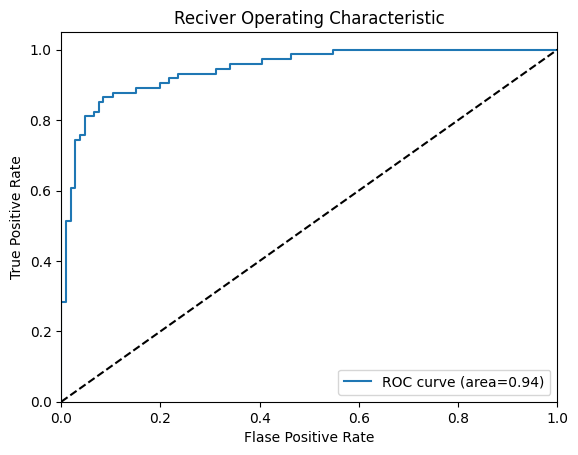

6/6 [==============================] - 1s 138ms/step
0.9318066801619433


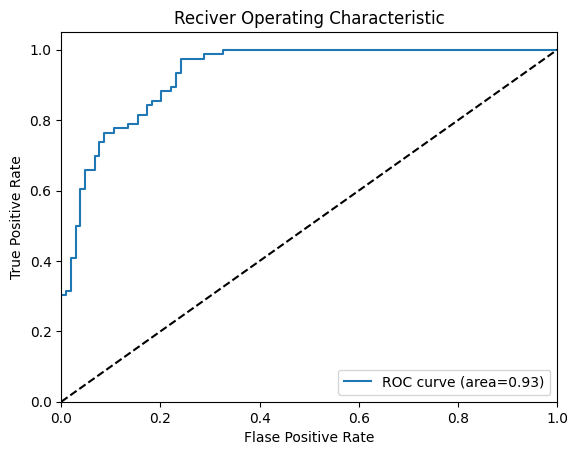

6/6 [==============================] - 1s 140ms/step
0.9182814890362061


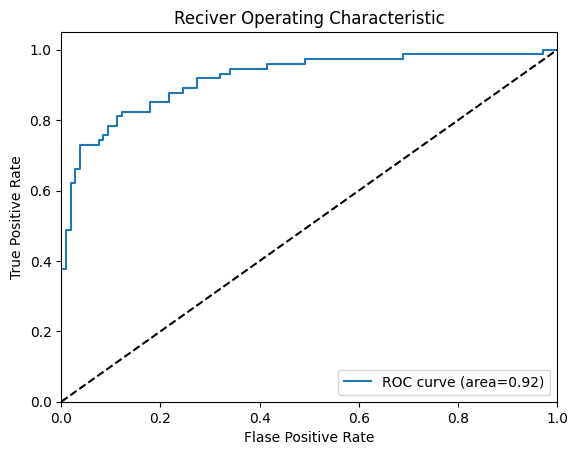

6/6 [==============================] - 1s 141ms/step
0.9378858024691359


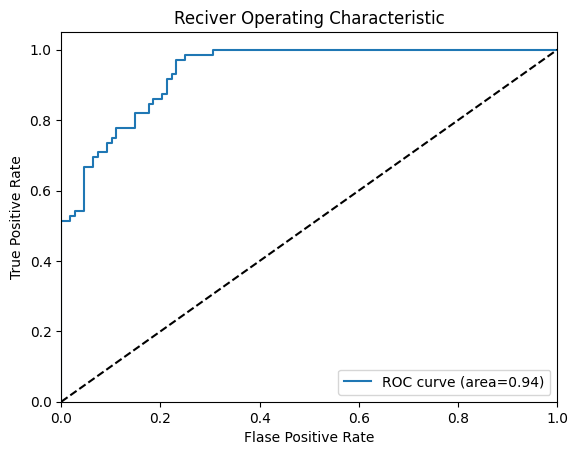

6/6 [==============================] - 1s 140ms/step
0.936594427244582


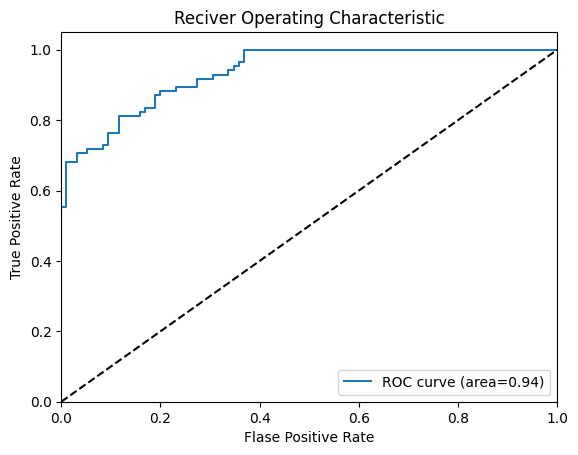

6/6 [==============================] - 1s 140ms/step
0.9070922866724631


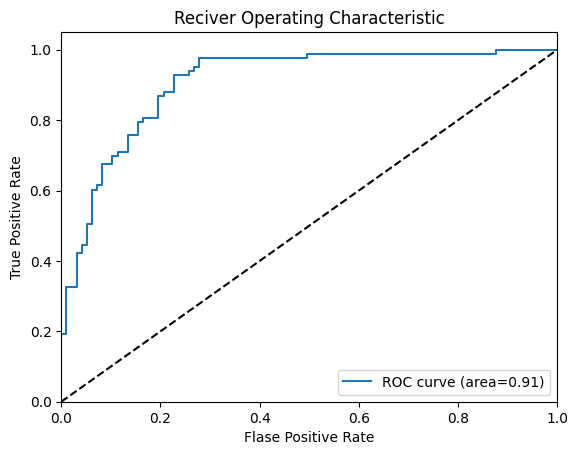

6/6 [==============================] - 1s 141ms/step
0.9310475708502024


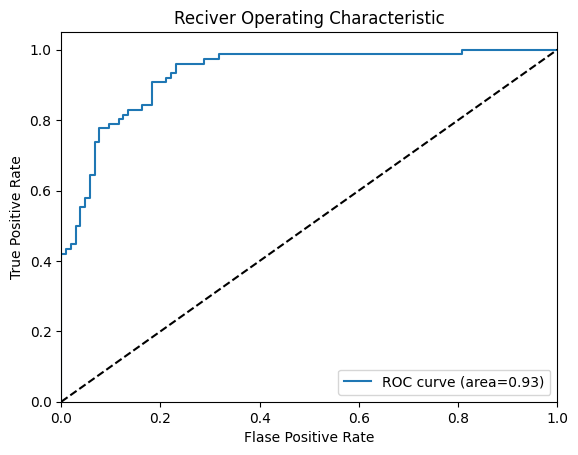

6/6 [==============================] - 1s 142ms/step
0.9427246522120567


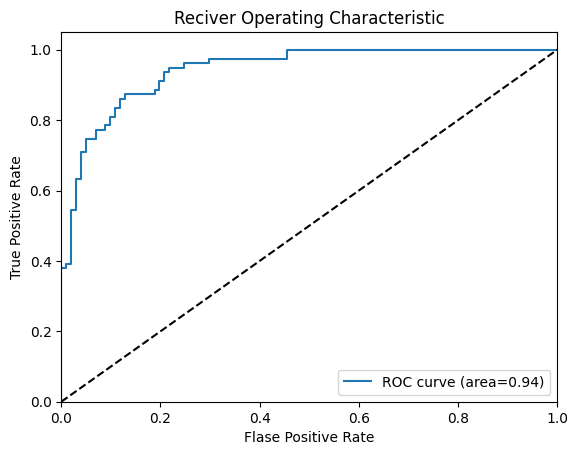

6/6 [==============================] - 1s 141ms/step
0.9499432606228723


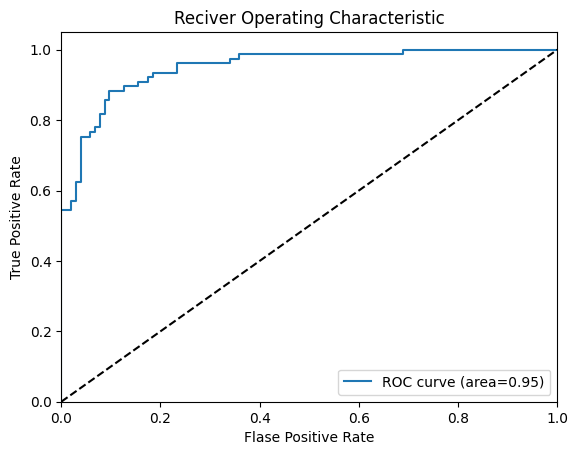

6/6 [==============================] - 1s 142ms/step
0.9307500000000001


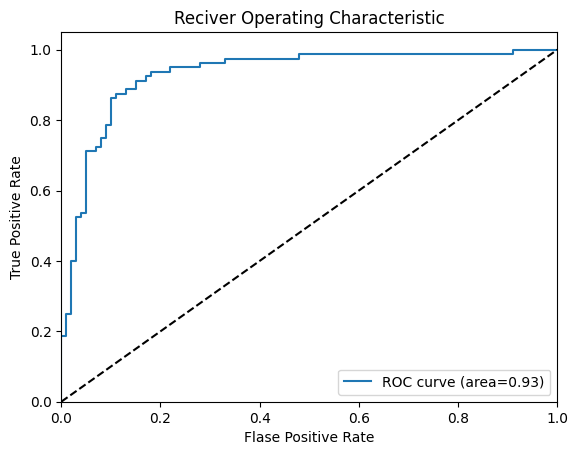

In [7]:
vgg19_sns,vgg19_spc,vgg19_auc,vgg19_val_loss,vgg19_val_acc=sir_method(VGG19,224,224)

In [8]:
print(f'Mean sensitivity of VGG19 after 10 epochs {np.mean(vgg19_sns)}')
print(f'Mean specificity of VGG19 after 10 epochs {np.mean(vgg19_spc)}')
print(f'Mean AUC of VGG19 after 10 epochs {np.mean(vgg19_auc)}')

Mean sensitivity of VGG19 after 10 epochs 0.751304338607597
Mean specificity of VGG19 after 10 epochs 0.8585649740962769
Mean AUC of VGG19 after 10 epochs 0.9257437697697967


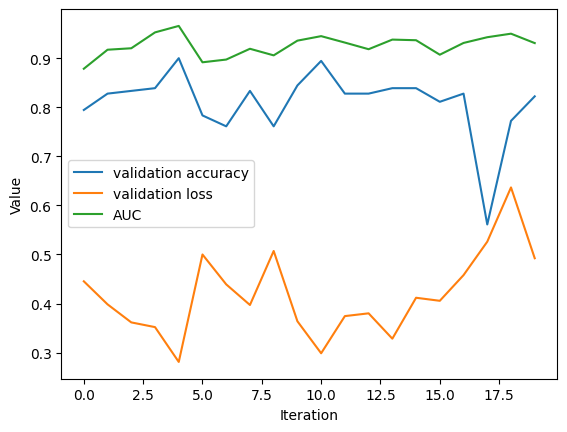

In [9]:
# Generate x-axis values (indices of the data list)
x = range(len(vgg19_val_acc))

# Plot the data
plt.plot(x, vgg19_val_acc,label='validation accuracy')
plt.plot(x, vgg19_val_loss,label='validation loss')
plt.plot(x, vgg19_auc,label='AUC')
# Add labels and title to the plot
plt.xlabel('Iteration')
plt.ylabel('Value')
# plt.title('Plot of List of Values')
# Adding legend
plt.legend()
# Display the plot
plt.show()

## Fine Tuning of Mobile Net

In [10]:
#### SIR Newly Mentioned Logic of sampling
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
sns=[]
spc=[]
AUC=[]
validation_loss=[]
validation_accuracy=[]
# Assuming you have your feature data in 'X' and labels in 'y'
# Define your model as 'model'
# Define the number of epochs as 'num_epochs'
def sir_method_fine_tuned_model(base,height,width):
# Get the total number of samples
  num_samples = len(labels)
  num_epochs=10
  for epoch in range(num_epochs):
      # Shuffle the data and labels
      shuffled_indices = np.random.permutation(num_samples)
      X_shuffled = data[shuffled_indices]
      y_shuffled =labels[shuffled_indices]

      # Split the data into training and validation sets
      train_size = int(0.8 * num_samples)
      X_train, X_val = X_shuffled[:train_size], X_shuffled[train_size:]
      y_train, y_val = y_shuffled[:train_size], y_shuffled[train_size:]
      base_model = base(weights='imagenet', include_top=False, input_shape=(height, width, 3))

        # Set up the model architecture
      model = Sequential()
      model.add(base_model)
      model.add(Flatten())
      model.add(Dense(height, activation='relu'))
      model.add(Dropout(0.5))
      model.add(Dense(1, activation='sigmoid'))
      base_model.trainable = False

      # Compile the model
      model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
      # Train the model on the training set
      model.fit(X_train, y_train, epochs=1, batch_size=50, verbose=0)
      # Evaluate the model on the validation set
      val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
      validation_loss.append(val_loss)
      validation_accuracy.append(val_acc)
      # Make predictions on the validation set
      y_pred = model.predict(X_val)
      # y_pred_binary = (y_pred >= 0.5).astype(int)
      # Calculate the ROC curve
      fpr1, tpr1, thresholds = roc_curve(y_val, y_pred)
      # Calculate sensitivity, specificity, and AUC
      cm = confusion_matrix(y_val, np.round(y_pred))
      tn, fp, fn, tp = cm.ravel()
      sensitivity = tp / (tp + fn)
      specificity = tn / (tn + fp)
      auc1 = roc_auc_score(y_val, y_pred)
      sns.append(sensitivity)
      spc.append(specificity)
      AUC.append(auc1)
      print(epoch)
      print(auc1)
      # print(roc_auc)
      plt.plot(fpr1, tpr1, color='darkorange', lw=2, )
      plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Receiver Operating Characteristic (ROC)')
      plt.legend(loc="lower right")
      plt.show()
      # Print the evaluation metrics
      # print(f"Epoch {epoch+1} - Sensitivity: {sensitivity:.4f} - Specificity: {specificity:.4f} - AUC: {auc:.4f}")
  return sns,spc,AUC,validation_loss,validation_accuracy


6/6 [==============================] - 1s 33ms/step


0
0.9963549522373052


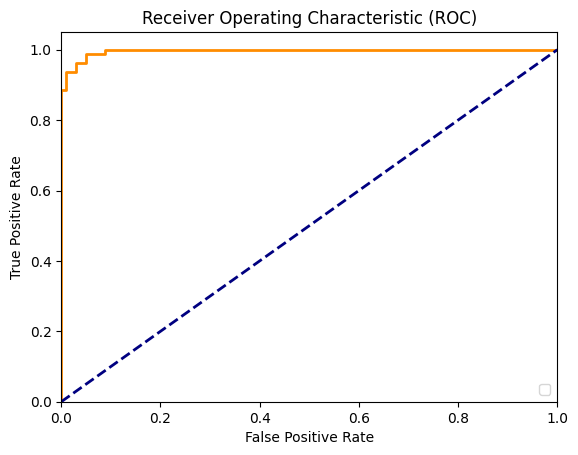

6/6 [==============================] - 1s 33ms/step


1
0.9973993808049536


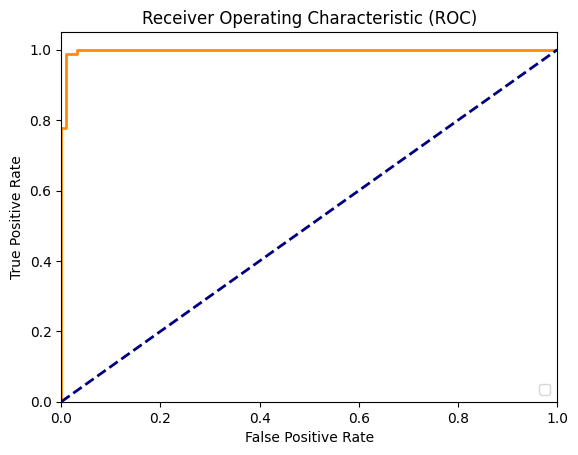

6/6 [==============================] - 1s 34ms/step
2
0.9815479876160991


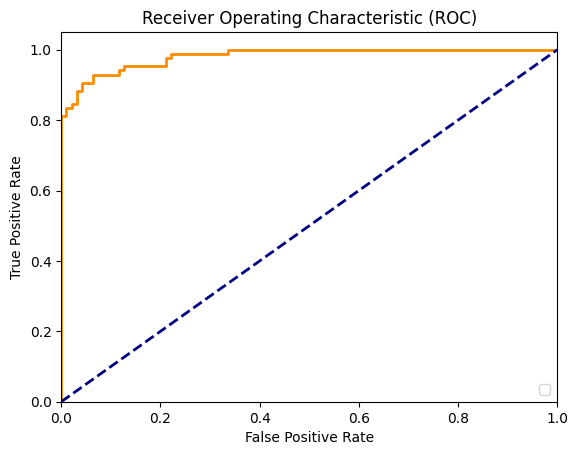

6/6 [==============================] - 1s 33ms/step
3
0.9981249999999999


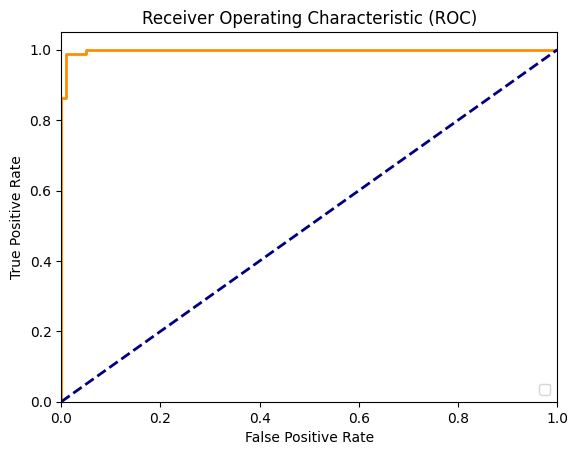

6/6 [==============================] - 1s 33ms/step


4
0.9909549037343326


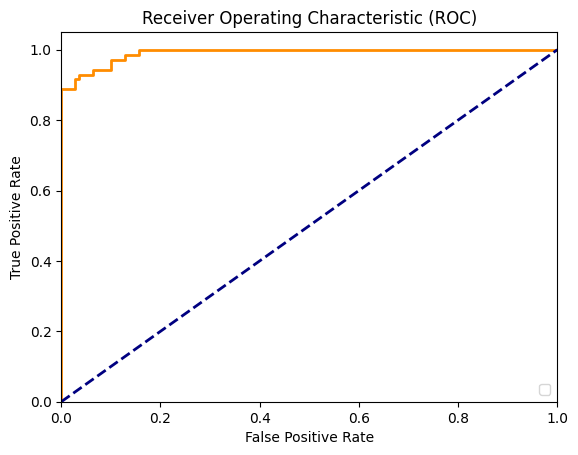

6/6 [==============================] - 1s 33ms/step


5
0.98775


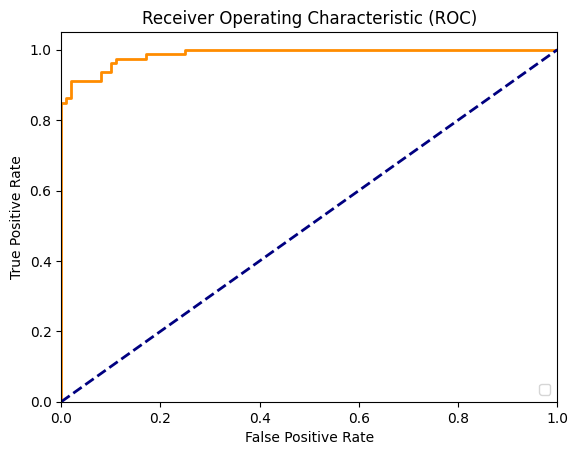

6/6 [==============================] - 1s 34ms/step


6
0.997730424914891


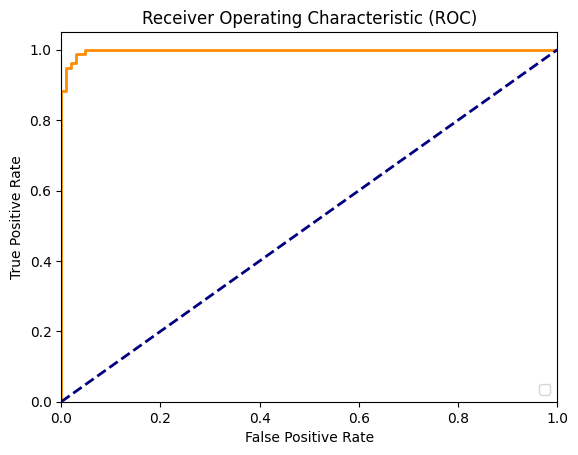

6/6 [==============================] - 1s 36ms/step


7
0.9976356396217023


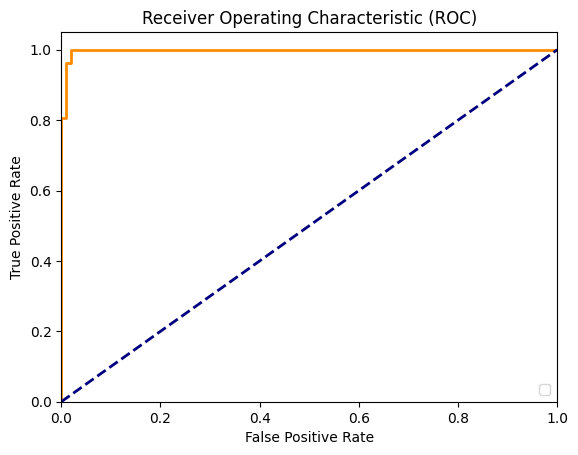

6/6 [==============================] - 1s 32ms/step


8
0.9908088235294117


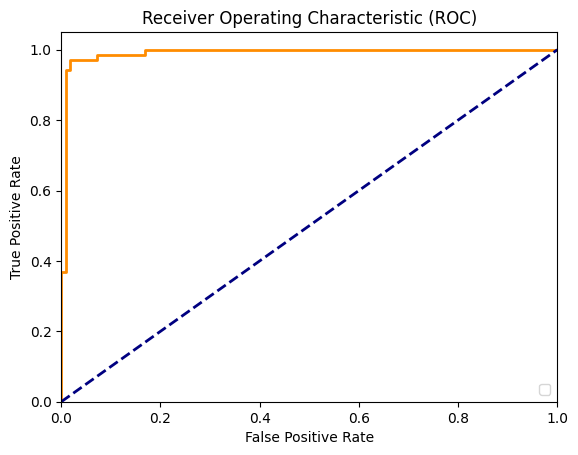

6/6 [==============================] - 1s 35ms/step


9
0.9942857142857143


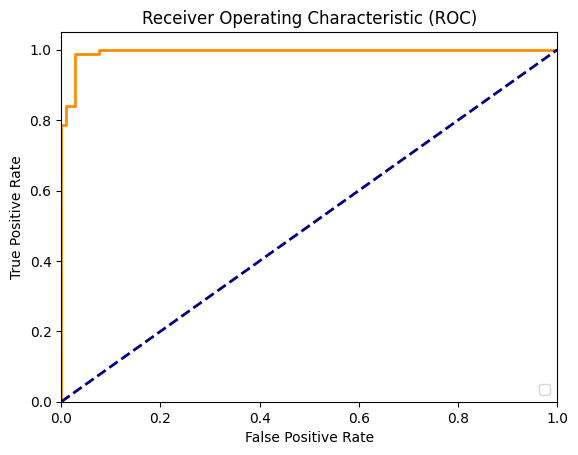

In [11]:
fine_tuned_sns,fine_tuned_spc,fine_tuned_auc,fine_tuned_val_loss,fine_tuned_val_acc=sir_method_fine_tuned_model(MobileNet,224,224)

In [12]:
print(f'Mean sensitivity of fine tuned MobileNet after 10 epochs {np.mean(fine_tuned_sns)}')
print(f'Standard deviation sensitivity of fine tuned MobileNet after 10 epochs {np.var(fine_tuned_sns)}')
print(f'Mean specificity of fine tuned MobileNet after 10 epochs {np.mean(fine_tuned_spc)}')
print(f'Standard deviation specificity of fine tuned MobileNet after 10 epochs {np.var(fine_tuned_spc)}')
print(f'Mean AUC of fine tuned MobileNet after 10 epochs {np.mean(fine_tuned_auc)}')
print(f'Standard deviation AUC of fine tuned MobileNet after 10 epochs {np.var(fine_tuned_auc)}')

Mean sensitivity of fine tuned MobileNet after 10 epochs 0.9365491132627147
Standard deviation sensitivity of fine tuned MobileNet after 10 epochs 0.005356484016415176
Mean specificity of fine tuned MobileNet after 10 epochs 0.9650137248914934
Standard deviation specificity of fine tuned MobileNet after 10 epochs 0.000949831457163983
Mean AUC of fine tuned MobileNet after 10 epochs 0.993259282674441
Standard deviation AUC of fine tuned MobileNet after 10 epochs 2.6941750243327402e-05


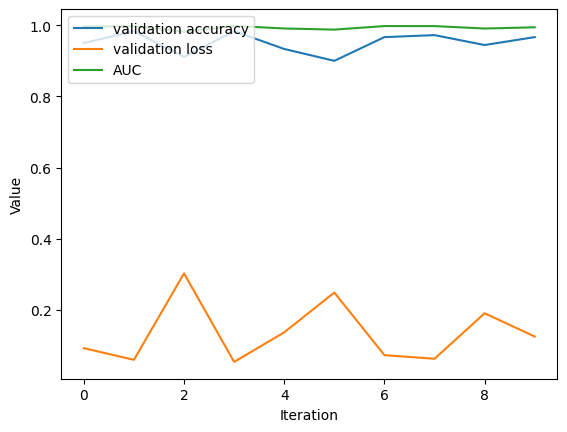

In [13]:
# Generate x-axis values (indices of the data list)
x = range(len(fine_tuned_val_acc))

# Plot the data
plt.plot(x, fine_tuned_val_acc,label='validation accuracy')
plt.plot(x, fine_tuned_val_loss,label='validation loss')
plt.plot(x, fine_tuned_auc,label='AUC')
# Add labels and title to the plot
plt.xlabel('Iteration')
plt.ylabel('Value')
# plt.title('Plot of List of Values')
# Adding legend
plt.legend(loc='upper left')
# Display the plot
plt.show()

In [14]:
#### Exprimenting with the epoch number 20
#### SIR Newly Mentioned Logic of sampling
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
sns=[]
spc=[]
AUC=[]
validation_loss=[]
validation_accuracy=[]

# Assuming you have your feature data in 'X' and labels in 'y'
# Define your model as 'model'
# Define the number of epochs as 'num_epochs'
def sir_method(base,height,width):
# Get the total number of samples
  num_samples = len(labels)
  num_epochs=20
  for epoch in range(num_epochs):
      # Shuffle the data and labels
      shuffled_indices = np.random.permutation(num_samples)
      X_shuffled = data[shuffled_indices]
      y_shuffled =labels[shuffled_indices]

      # Split the data into training and validation sets
      train_size = int(0.8 * num_samples)
      X_train, X_val = X_shuffled[:train_size], X_shuffled[train_size:]
      y_train, y_val = y_shuffled[:train_size], y_shuffled[train_size:]
      base_model = base(weights='imagenet', include_top=False, input_shape=(height, width, 3))

        # Set up the model architecture
      model = Sequential()
      model.add(base_model)
      model.add(Flatten())
      model.add(Dense(height, activation='relu'))
      model.add(Dropout(0.5))
      model.add(Dense(1, activation='sigmoid'))
      base_model.trainable = False

      # Compile the model
      model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
      # Train the model on the training set
      model.fit(X_train, y_train, epochs=1, verbose=0)
      # Evaluate the model on the validation set
      val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
      validation_loss.append(val_loss)
      validation_accuracy.append(val_acc)
      # Make predictions on the validation set
      y_pred = model.predict(X_val)
      # y_pred_prob = model.predict_proba(X_val)[:, 1]

      # Calculate sensitivity, specificity, and AUC
      cm = confusion_matrix(y_val, np.round(y_pred))
      tn, fp, fn, tp = cm.ravel()
      sensitivity = tp / (tp + fn)
      specificity = tn / (tn + fp)
      auc = roc_auc_score(y_val, y_pred)
      # roc_auc = roc_auc_score(y_val, y_pred_prob)
            # Calculate the ROC curve
      fpr1, tpr1, thresholds = roc_curve(y_val, y_pred)
      sns.append(sensitivity)
      spc.append(specificity)
      AUC.append(auc)

      # ROC_AUC.append(roc_auc)
      # Print the evaluation metrics
      # print(f"Epoch {epoch+1} - Sensitivity: {sensitivity:.4f} - Specificity: {specificity:.4f} - AUC: {auc:.4f}")
  return sns,spc,AUC,validation_loss,validation_accuracy


6/6 [==============================] - 1s 39ms/step
Mean sensitivity of MobileNet after 20 epochs 0.9255495188440322
Mean specificity after 20 epochs 0.9658423320410175
Mean AUC after 20 epochs 0.9914179803470512


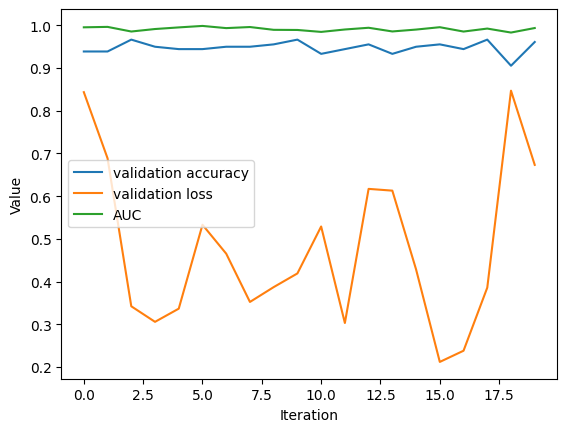

In [15]:
mobile_net_sns,mobile_net_spc,mobile_net_auc,mobile_net_val_loss,mobile_net_val_acc=sir_method(MobileNet,224,224)
print(f'Mean sensitivity of MobileNet after 20 epochs {np.mean(mobile_net_sns)}')
print(f'Mean specificity after 20 epochs {np.mean(mobile_net_spc)}')
print(f'Mean AUC after 20 epochs {np.mean(mobile_net_auc)}')
# Generate x-axis values (indices of the data list)
x = range(len(mobile_net_val_acc))

# Plot the data
plt.plot(x, mobile_net_val_acc,label='validation accuracy')
plt.plot(x, mobile_net_val_loss,label='validation loss')
plt.plot(x, mobile_net_auc,label='AUC')
# Add labels and title to the plot
plt.xlabel('Iteration')
plt.ylabel('Value')
# plt.title('Plot of List of Values')
# Adding legend
plt.legend()
# Display the plot
plt.show()